In [1]:
%load_ext autoreload
%autoreload 2

from icp_pred.arg_utils import is_notebook, get_cfg
cfg = get_cfg()
# choices
classical_models = ["linear", "xgb", "rf"]
nn_models = ["mlp", "rnn", "clip", "gpt"]
# override variables to experiment in notebook
if is_notebook():    
    cfg["auto_lr_find"] = False
    cfg["inner_folds"] = 0
    cfg["target_name"] = "ICP_Vital"   # ICP_Vital" , long_icp_hypertension_2
    cfg["db_name"] = "UKE"  # "UKE", "MIMIC", "eICU"
    cfg["minutes"] = 60
    
    cfg["model_type"] = "xgb"
    #cfg["gpt_name"] = "distilgpt2"  # distilgpt2, gpt2, gpt2-medium, gpt2-large(too large)
    #cfg["reduction_factor"] = 16
    
    cfg["use_lens"] = True
    
    cfg["randomly_mask_aug"] = 0.0
    cfg["target_nan_quantile"] = 0.9999
    cfg["target_clip_quantile"] = 0.999

    # do experiments on:  fill_type, target_nan_quantile, train_noise_std, 
    #  min_len(increase from 20 to higher), grad_clip_val (at 1 so far), weight_decay (at 0.2 so far)
    
    #cfg["norm_method"] = None # z, or none
    
    cfg["bs"] = 32 # 8 best for rnn, 32 for GPT
    
    cfg["use_in_mapping"] =  False
    cfg["use_out_mapping"] =  False

    # classical model args
    cfg["flat_block_size"] = 0
    # general args
    cfg["max_epochs"] = 10
    cfg["block_size"] = 28
    
    
    cfg["fill_type"] = "ffill" # "none", "pat_mean", "median", "pat_ema" "pat_ema_mask"
    cfg["use_nan_embed"] = False
    cfg["norm_nan_embed"] = True
    cfg["nan_embed_size"] =  128
    cfg["use_nan_embed_transformer"] = 0
    cfg["nan_embed_transformer_n_layers"] = 3
    cfg["nan_embed_transformer_n_heads"] = 8
    
    cfg["weight_decay"] = 0.02
    cfg["grad_clip_val"] = 1.0
    cfg["use_huber"] = 0
    
    cfg["lr"] = 3e-4
    cfg["agg_meds"] = True
    
    # rnn params
    cfg["rnn_type"] = "gru"
    cfg["rnn_layers"] = 1
    
    
    # transformer stats for gpt2
    # 4.338-4.8GB with adapters and batch size 16 and 117 secs
    # 6.620GB with adapters and batch size 32 and only 100 secs
    # 11.074 GB with adapters and batch size 64 and 92 secs
    # also 4.864GB with train_mlp_norm and 127 secss
    # all get to r2 of around 0.48

    # transformer stats for gptneo1.3
    # bs8 2.1GB, 

    # rnn stats for hidden layers size 2048
    # bs 64, 5084MB, 40 secs.
    # bs 128, 8632MB, 38 secs.

    # transformer params
    cfg["mode"] = "adapters"  # "adapters", "train_mlp_norm",  "train_norm", "freeze" (does not train)
    cfg["gpu"] = 1
    
    cfg["num_transformer_blocks"] = 3
    cfg["hidden_size"] = 256
    cfg["n_heads"] = 8
    cfg["dropout"] = 0.2
    
    cfg["seed"] = 0
    cfg["subsample"] = 0.9
    cfg["colsample_bytree"] = 0.9
    
#best_params = {'lr': 0.00023369063418158352, 'weight_decay': 0.18, 'grad_clip_val': 0.1, 'reduction_factor': 4.0, 'randomly_mask_aug': 0.12}
#for k,v in best_params.items():
#    cfg[k] = v
    
    
# overrides and calculated default vals
if cfg["lr"] is None:
    model_type = cfg["model_type"]
    if model_type == "clip":
        cfg["lr"] = 0.001
    elif model_type == "gpt":
        # bs 8 and gpt2 take 9.8GB with max seq len of 512
        # bs 16 with max seq len of 256
        # bs 32 with max seq len 128 only 7.4GB, good performance and fast - 6.9 if mlp_norm
        # bs 64 with len 128 and mlp_norm = 10.9GB. 9.4GB for freeze
        cfg["lr"] = 0.00005
    else:
        cfg["lr"] = 0.0001  # 0.01 works kind of for nan_embed

if cfg["fill_type"] == "none":
    cfg["use_nan_embed"] = 1
        
#cfg["val_check_interval"] = int(cfg["val_check_interval"] * (32 / cfg["batch_size"]))
    
import pytorch_lightning as pl
pl.utilities.seed.seed_everything(seed=cfg["seed"], workers=False)
locals().update(cfg)

/home/anton/.local/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/home/anton/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/anton/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/anton/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/anton/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResou

In [2]:
cfg["model_type"] = "rnn"
cfg["max_epochs"] = 5
cfg["agg_meds"] = 1
cfg["block_size"] = 128

best = {'model_type': 'rnn',
 'db_name': 'UKE',
 'inner_folds': 4,
 'agg_meds': 1,
 'norm_targets': 1,
 'fill_type': 'ffill',
 'bs': 8, #2,
 'max_epochs': 20,#10,
 'lr': 0.0034775665304268,
 'weight_decay': 0.26,
 'grad_clip_val': 0.5,
 'dropout': 0.1,
 'hidden_size': 512,
 'rnn_layers': 1,
 'rnn_type': 'gru',

 'gpt_name': 'gpt2',
 'n_estimators': 50.0,
 'max_depth': 6,
 'gamma': 0.0,
 'subsample': 1.0,
 'colsample_bytree': 1.0,
 'gpu': 1,
 'opt_steps': 100,
 'flat_block_size_range': 0}

#for key in best:
#    cfg[key] = best[key]

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(cfg["gpu"])

import torch
import pytorch_lightning as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

import logging
import pytorch_lightning
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
#pytorch_lightning.utilities.distributed.log.setLevel(logging.ERROR)

In [4]:
# load df
path = f'data/DB_{cfg["db_name"]}_{cfg["minutes"]}_final_df.parquet'
df = pd.read_parquet(path)
print(df.shape)
# drop columns that are completely NaN
#df = df.dropna(axis=1, how="all")
#print(df.shape)
# drop columns that are completely zero
#mean_zeros = (df == 0).mean()
#df = df[list(mean_zeros[mean_zeros < 1.0].index)]
#df = df[((df == 0).mean() < 0.9999).index]
#print(df.shape)

(288331, 90)


In [5]:
# drop rel time
#df = df.drop(columns=["rel_time"])

In [6]:
print(len(df))
print(df["ICP_Vital"].describe())
print(df.isna().mean().mean())
print(df["ICP_Vital"].isna().mean())

288331
count    243143.000000
mean         13.142286
std          10.524949
min         -23.000000
25%           8.000000
50%          12.000000
75%          16.000000
max         298.000000
Name: ICP_Vital, dtype: float64
0.41958358815235114
0.15672265555906234


In [7]:
[f for f in df.columns if "ICP" in f]

['ICP_Vital', 'ICP_Vital_std']

In [8]:
# create datamodule with dataloaders
from icp_pred.train_utils import make_train_val_fold

dms = make_train_val_fold(df, cfg, cfg["inner_folds"])
dm = dms[0]

In [9]:
# print input shapes 
for dm in dms:
    print(dm.train_ds.flat_inputs.shape)
    print(dm.train_ds.flat_targets.shape)

(181860, 73)
(181860,)


In [10]:
# print quantiles
train_ds = dm.train_ds
if hasattr(train_ds, "lower_target_nan_quantile"):
    print("NaN quantiles:", train_ds.lower_target_nan_quantile, train_ds.upper_target_nan_quantile)
    print("Clip quantiles:", train_ds.lower_target_clip_quantile, train_ds.upper_target_clip_quantile)

NaN quantiles: -14.26835000000085 134.53669999999693
Clip quantiles: -7.133000063419295 102.0


In [11]:
print(len(train_ds.feature_names))
train_ds.feature_names

73


Index(['rel_time', 'AF_Vital', 'AF_Vital_std', 'ALT_Labor', 'AST_Labor',
       'Albumin_Labor', 'Bili_BGA', 'CK_Labor', 'CRP_Labor', 'Ca_BGA',
       'Cl_BGA', 'EVB_Labor', 'Erythrocyten_Labor', 'FCOHb_BGA', 'FiO2_Vital',
       'Freq spontan_Vital', 'GCS_auge_Vital', 'GCS_motor_Vital',
       'GCS_verbal_Vital', 'Glu_BGA', 'HCO3_BGA', 'HF_Vital', 'HF_Vital_std',
       'Harnstoff-N_Labor', 'Hb_BGA_BGA', 'INR_Labor', 'K_BGA',
       'Kreatinin_Labor', 'LDH_Labor', 'Lac_BGA', 'Leukocyten_Labor',
       'Lipase_Labor', 'MCHC_Labor', 'MCH_Labor', 'MCV_Labor',
       'Magnesium_Labor', 'Na_BGA', 'PCO2_BGA', 'PEEP_Vital', 'PO2_BGA',
       'Phosphat_Labor', 'Pmean_Vital', 'Ppeak_Vital', 'Pupille li_Vital',
       'Pupille re_Vital', 'RASS_Vital', 'SpO2_Vital', 'SpO2_Vital_std',
       'TZ_Labor', 'Temp_Vital', 'Temp_Vital_min', 'Temp_Vital_std',
       'Thrombocyten_Labor', 'Triglyceride_Labor', 'aPTT_Labor', 'diast_Vital',
       'diast_Vital_std', 'mittl_Vital', 'pH_BGA', 'sO2_BGA', 'sys

In [12]:
print(cfg)

{'model_type': 'rnn', 'target_name': 'ICP_Vital', 'db_name': 'UKE', 'minutes': 60, 'model_size': 'base', 'outer_folds': 3, 'inner_folds': 0, 'auto_lr_find': False, 'agg_meds': 1, 'norm_targets': True, 'seed': 0, 'features': None, 'fill_type': 'ffill', 'target_nan_quantile': 0.9999, 'input_nan_quantile': 0.9999, 'target_clip_quantile': 0.999, 'input_clip_quantile': 0.999, 'random_starts': True, 'randomly_mask_aug': 0.0, 'tune_masking': False, 'freeze_nan_embed': 0, 'norm_nan_embed': True, 'nan_embed_size': 128, 'use_nan_embed_transformer': 0, 'nan_embed_transformer_n_layers': 3, 'nan_embed_transformer_n_heads': 8, 'subsample_frac': 1.0, 'train_noise_std': 0.01, 'bs': 32, 'max_len': 1024, 'min_len': 0, 'block_size': 128, 'max_epochs': 5, 'lr': 0.0003, 'use_nan_embed': False, 'weight_decay': 0.02, 'grad_clip_val': 1.0, 'val_check_interval': None, 'max_steps': -1, 'use_macro_loss': False, 'use_pos_weight': True, 'use_huber': 0, 'dropout': 0.2, 'hidden_size': 256, 'use_static': False, 'use_

In [13]:
train_iter = iter(dm.train_dataloader())

In [14]:
# test dataloader
inputs, targets, lens = next(train_iter)
#print(dm.feature_names)
print(inputs.shape, inputs.min(), inputs.max())
print(targets.shape)
print(targets[~torch.isnan(targets)].mean())
print(lens)
print(lens.float().mean(), lens.max())
# NaNs in inputs
nan_inputs = torch.isnan(inputs).any(dim=1)
print("Nans total and percentage: ", nan_inputs.sum(), nan_inputs.sum().float() / nan_inputs.numel())

torch.Size([32, 128, 73]) tensor(-10.3462) tensor(30.8994)
torch.Size([32, 128, 1])
tensor(0.1307)
tensor([128, 114, 128, 122, 128, 128,  91,  55,  22, 128,   7,  16, 128, 128,
        128, 102, 128, 128, 128, 128, 128, 128, 128,  85, 128, 128,  93, 128,
        128,  66,  78, 128])
tensor(106.5938) tensor(128)
Nans total and percentage:  tensor(0) tensor(0.)


In [15]:
import importlib
import icp_pred.train_utils
import icp_pred.model
import icp_pred.nan_emb
importlib.reload(icp_pred.nan_emb)
importlib.reload(icp_pred.train_utils)
importlib.reload(icp_pred.model)

<module 'icp_pred.model' from '/home/anton/icp_prediction/icp_pred/model.py'>

In [16]:
cfg["use_nan_embed_transformer"] = 0
cfg["nan_embed_size"] =  128

Sizes:
- Tiny - 120 K
- Small - 250 K
- Base - 1 M
- Large - 4 M
- XL - 16 M

## LSTM:
First is hidden size, second num layers
- 38   K = 64 , 1
- 140  K = 128, 1
- 240  K = 128, 2
- 940  K = 256, 2
- 3.7  M = 512, 2
- 14.8 M = 1024, 2 - 2.5 GB VRAM with block size 128 and bs 256


## Transformer:
First hidden size, second num blocks
- 40.5 K = 32, 3
- 155 K = 64, 3
- 255 K = 64, 5
- 1   M = 128, 5
- 4   M = 256, 5
- 15.8 M = 512, 5 - 6.8 GB VRAM with block size 128, bs 256

- 15.8 M = 256, 20  - OOM with block size 128, bs 256. 2.6 GB with bs 64

In [17]:
cfg["model_type"] = "transformer"
cfg["hidden_size"] = 32
cfg["num_transformer_blocks"] = 3
cfg["n_heads"] = 8
cfg["bs"] = 32

In [18]:
cfg["model_type"] = "rnn"

cfg["use_in_mapping"] = 1
cfg["use_out_mapping"] = 1
cfg["rnn_layers"] = 1
cfg["hidden_size"] = 64
cfg["bs"] = 256

In [19]:
cfg["model_size"] = None

In [20]:
from icp_pred.train_utils import create_model

# disable transformers logger warnings
import logging
import transformers
logging.getLogger("transformers").setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

if cfg["model_type"] in ["mlp", "gpt", "rnn", "transformer"]:
    model = create_model(cfg["model_type"], dms[0], cfg)
    
    # print param count
    count = 0
    trainable_param_count = 0
    for n, p in model.named_parameters():
        #print(n, p.shape, p.numel())
        count += p.numel()
        if p.requires_grad:
            trainable_param_count += p.numel()
    print(f"{count / 1000:.1f}, K" if count < 1000000 else f"{count / 1000000:.1f}, M")
    #print(trainable_param_count / 1000, "K")
    
    # set out_mapping weights to 1 to check output scale of pretrained
    #model.out_mapping.weight = torch.nn.Parameter(torch.ones_like(model.out_mapping.weight))
    
    # test model prediction shape on test sample from above
    outs = []
    # get some test preds
    for _ in range(5):
        inputs, targets, lens = next(train_iter)
        with torch.no_grad():
            out = model(inputs, lens)
        outs.append(out)
        print(out.shape, out.requires_grad)
        print(out.mean(), out.std())
else:
    model = None

38.1, K
torch.Size([32, 128, 1]) False
tensor(-0.1140) tensor(0.0252)
torch.Size([32, 128, 1]) False
tensor(-0.1157) tensor(0.0210)
torch.Size([32, 128, 1]) False
tensor(-0.1134) tensor(0.0222)
torch.Size([32, 128, 1]) False
tensor(-0.1145) tensor(0.0210)
torch.Size([32, 128, 1]) False
tensor(-0.1138) tensor(0.0248)


In [21]:
#list(model.embed[0].transformer_encoder.named_parameters())

In [22]:
#model.embed[0].transformer_encoder.layers[0].self_attn.out_proj.weight.dtype

In [23]:
import icp_pred.model
import icp_pred.train_utils
import icp_pred.nan_emb
import importlib
importlib.reload(icp_pred.model)
importlib.reload(icp_pred.train_utils)
importlib.reload(icp_pred.nan_emb)

<module 'icp_pred.nan_emb' from '/home/anton/icp_prediction/icp_pred/nan_emb.py'>

In [24]:
cfg["lr"] = 3e-4

In [25]:
cfg["max_epochs"] = 10

In [26]:
#cfg["lr"] = 0.0003

In [27]:
# train model on datamodule
from icp_pred.train_utils import train_model

models, trainers = train_model(cfg["model_type"], dms, cfg, verbose=True, log=False)

Number of trainable parameters:  38081


/home/anton/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/anton/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


Sanity Checking: 0it [00:00, ?it/s]

/home/anton/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/anton/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [28]:
torch.cuda.empty_cache()
import gc
gc.collect()

211

In [29]:
import icp_pred.eval_utils
from icp_pred.eval_utils import get_all_dfs, print_all_metrics
import importlib
importlib.reload(icp_pred.eval_utils)
# eval
dl_type = "val"
#dl = external_dls["MIMIC"] # external_dls - MIMIC, eICU, UKE
dl = None

pred_df = get_all_dfs(models, dms, cfg["model_type"], dm.regression, 
                      dl_type=dl_type, dl=dl, norm_targets=cfg["norm_targets"])

<AxesSubplot:>

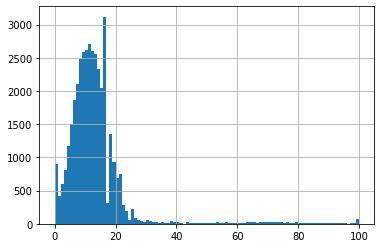

In [30]:
pred_df.targets.clip(0, 100).hist(bins=100)

<AxesSubplot:>

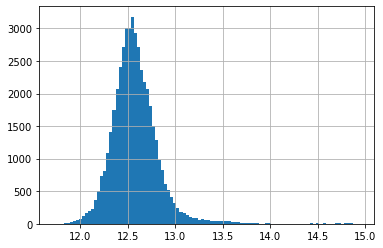

In [31]:
pred_df.preds.hist(bins=100)

In [32]:
# create new df with randomly shuffled targets to debug
shuffled_pred_df = pred_df.copy()
shuffled_pred_df["targets"] = np.random.permutation(shuffled_pred_df["targets"])
mse = (shuffled_pred_df["preds"] - shuffled_pred_df["targets"]) ** 2
mse.mean(), np.sqrt(mse.mean())

(126.68453295635172, 11.255422380184216)

In [33]:
# mse of mean train target
mse = (pred_df["targets"] - pred_df["mean_train_target"]) ** 2
mse.mean(), np.sqrt(mse.mean())

(126.56728114489873, 11.250212493322014)

In [34]:
# our mse
mse = (pred_df["preds"] - pred_df["targets"]) ** 2
mse.mean(), np.sqrt(mse.mean())

(126.49757328298497, 11.247113997954541)

In [35]:
pred_df.groupby("model_id").error.mean()#.hist(bins=10)

model_id
0    1.176845
Name: error, dtype: float32

In [36]:
pred_df

,targets,preds,ids,step,error,model_id,mean_train_target,std_train_target
0,-5.999999,12.525763,0.0,0,3.192929,0,13.21842,10.367677
1,-8.499998,12.481745,0.0,1,4.095625,0,13.21842,10.367677
2,-8.000000,12.497239,0.0,2,3.908659,0,13.21842,10.367677
3,-8.000000,12.498789,0.0,3,3.909250,0,13.21842,10.367677
4,-8.999998,12.488508,0.0,4,4.295854,0,13.21842,10.367677
...,...,...,...,...,...,...,...,...
46188,-0.666667,12.627929,194.0,307,1.644324,0,13.21842,10.367677
46189,0.666667,12.640356,194.0,308,1.333807,0,13.21842,10.367677
46190,-0.499999,12.572883,194.0,309,1.589936,0,13.21842,10.367677
46191,-0.999999,12.593616,194.0,310,1.719123,0,13.21842,10.367677


In [37]:
import importlib

import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import icp_pred.eval_utils
importlib.reload(icp_pred.eval_utils)
from icp_pred.eval_utils import get_all_dfs, hypertension_acc, hypertension_auc

def calculate_metrics(df):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    pred_targets = df["targets"].dropna()
    preds = df["preds"][~df["targets"].isna()]
    metrics = {"mse": mean_squared_error(pred_targets, preds),
                "mae": mean_absolute_error(pred_targets, preds),
                "rmse": np.sqrt(mean_squared_error(pred_targets, preds)),
                "min_abs_error": (preds - pred_targets).abs().min(),
                "max_abs_error": (preds - pred_targets).abs().max(),
                "hyp_acc": hypertension_acc(pred_targets, preds),
                "hyp_auc": hypertension_auc(pred_targets, preds),
                "r2": r2_score(pred_targets, preds),
                "baseline_mse": mean_squared_error(pred_targets, df["mean_train_target"][~df["targets"].isna()]),
                "baseline_rmse": np.sqrt(mean_squared_error(pred_targets, df["mean_train_target"][~df["targets"].isna()])),
                "baseline_hyp_acc": hypertension_acc(pred_targets, df["mean_train_target"][~df["targets"].isna()]),
                "baseline_hyp_auc": hypertension_auc(pred_targets, df["mean_train_target"][~df["targets"].isna()]),
                "baseline_r2": r2_score(pred_targets, df["mean_train_target"][~df["targets"].isna()]),
                }
    return metrics

if dm.regression:
    #from eval_utils import hypertension_acc
    pred_targets = pred_df["targets"].dropna()
    preds = pred_df["preds"][~pred_df["targets"].isna()]
    print("Baseline acc for hypertension: ", hypertension_acc(pred_targets, np.zeros((len(pred_targets,)))))
    print("Accuracy for hypertension: ", hypertension_acc(pred_targets, preds))
    print("AUC for hypertension: ", hypertension_auc(pred_targets, preds))

    metrics = calculate_metrics(pred_df)
    
    print(metrics)
    print_all_metrics(pred_df)
else:
    
    # general metrics
    non_na_pred_df = pred_df.dropna(subset=["targets"])
    binary_preds = non_na_pred_df["preds"] > 0.5
    targets = non_na_pred_df["targets"]
    preds = torch.sigmoid(torch.tensor(non_na_pred_df["preds"].to_numpy())).numpy()
    
    auc = sklearn.metrics.roc_auc_score(targets, preds)
    tpr, fpr, threshs = sklearn.metrics.roc_curve(targets, preds)
    plt.plot(tpr, fpr)
    plt.plot([0, 1], [0, 1], linestyle="--", color="black")
    plt.title(f"ROC Curve - AUC {auc:.3f}")
    plt.show()
    
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(targets, preds)
    plt.plot(precision, recall)
    plt.xlabel("precision")
    plt.ylabel("recall")
    plt.show()
    
    matrix = sklearn.metrics.confusion_matrix(targets, binary_preds)
    cm_display = sklearn.metrics.ConfusionMatrixDisplay(matrix).plot()
    print(matrix)
    print("AUC: ", auc)
    print("Mean pred: ", preds.mean())
    
    print("Accuracy: ", sklearn.metrics.accuracy_score(targets, binary_preds))
    
    #train_pred_df = get_all_dfs(models, trainers, cfg["model_type"], dm.regression, dl_type="train", dl=None, calc_new_norm_stats=False)
    #non_na_df = train_pred_df.dropna(subset=["targets"])
    #tpr, fpr, threshs = sklearn.metrics.roc_curve(non_na_df["targets"], non_na_df["preds"])

Baseline acc for hypertension:  0.9433200476215124
Accuracy for hypertension:  0.9433200476215124
AUC for hypertension:  0.4730563978556051
{'mse': 126.497573282985, 'mae': 5.977913201750471, 'rmse': 11.247113997954543, 'min_abs_error': 0.00013919587908084452, 'max_abs_error': 137.98467131337753, 'hyp_acc': 0.9433200476215124, 'hyp_auc': 0.4730563978556051, 'r2': -0.00012092399450103208, 'baseline_mse': 126.56728114489873, 'baseline_rmse': 11.250212493322014, 'baseline_hyp_acc': 0.9433200476215124, 'baseline_hyp_auc': 0.5, 'baseline_r2': -0.0006720514940845579}
Performance over splits: 
            targets      preds     error
model_id                                
0         12.926868  12.577894  1.176845
Mean train target:  13.218420179278507
Mean/Std preds:  12.57541445591676 0.24517250372482705
Mean/Std targets:  12.926868118286855 11.246579575394737
Max error:  177.1327
Accuracy for hypertension baseline:  0.9433200476215124

Model metrics:
RMSE:  1.0848248
MSE:  1.176845
MAE:  5

In [38]:
# eval model new
#pred_df = get_all_dfs(models, dms, cfg["model_type"], dm.regression, dl_type=dl_type, dl=dl, norm_targets=cfg["norm_targets"])



In [39]:
#python3 tune.py inner_folds=5  agg_meds=1 norm_targets=1 fill_type="ffill"
#   opt_steps=50 flat_block_size=8 gpu=1 model_type="rnn" hidden_size=256,512,1024 rnn_layers=1,2,3 num_transformer_blocks=3 max_epochs=5 db_name="UKE","MIMIC" rnn_type="gru" -m



#python3 tune.py inner_folds=3  agg_meds=1 norm_targets=1 fill_type="ffill" opt_steps=10 
# flat_block_size=8 gpu=1 model_type="rnn" hidden_size=256 rnn_layers=1 max_epochs=5 db_name="UKE" rnn_type="gru" 




In [40]:
cfg["block_size"]

128

In [41]:
from icp_pred.eval_utils import make_eval_preds

all_targets, all_preds, all_raw_inputs = make_eval_preds(models, dms, cfg["block_size"],
                                                         restrict_to_block_size=cfg["block_size"] <= 16,
                                                        clip_targets=1, normalize_targets = cfg["norm_targets"],
                                                        split = "val",)

100%|████████████████████████████████████████| 195/195 [00:00<00:00, 771.27it/s]


In [42]:
no_na = pred_df.dropna(subset=["targets"])
pred_targets = [t.unsqueeze(0) for t in torch.tensor(no_na["targets"].to_numpy())]
preds = torch.tensor(no_na["preds"].to_numpy())

In [43]:
from icp_pred.eval_utils import calc_metrics

metrics, flat_targets, flat_preds = calc_metrics(pred_targets, preds)

metrics

{'mse': 126.49757,
 'mae': 5.9779134,
 'rmse': 11.247113,
 'min_abs_error': 0.00013923645,
 'max_abs_error': 137.98468,
 'hyp_acc': 0.9433200476215124,
 'hyp_auc': 0.47305631015951666,
 'r2': -0.00012092838777055803,
 'rmse_clin': 4.3580484,
 'mae_clin': 3.1928992,
 'hyp_acc_clin': 0.9568220320576865,
 'hyp_auc_clin': 0.48651650220019893}

In [44]:
from icp_pred.eval_utils import calc_metrics

metrics, flat_targets, flat_preds = calc_metrics(all_targets, all_preds)

metrics

{'mse': 121.69235,
 'mae': 5.9426928,
 'rmse': 11.031425,
 'min_abs_error': 0.0002002716,
 'max_abs_error': 89.75228,
 'hyp_acc': 0.9434879272012823,
 'hyp_auc': 0.4723623160597529,
 'r2': -0.00016620458154803508,
 'rmse_clin': 4.3578086,
 'mae_clin': 3.1935873,
 'hyp_acc_clin': 0.9569044006069802,
 'hyp_auc_clin': 0.48660400625856537}

In [46]:
dm.train_ds.preprocessor.mean_train_target

13.218420179278507

In [47]:
dm.preprocessor.mean_train_target

13.218420179278507

In [48]:
len(dm.val_ds)

195

In [49]:
pred_df

,targets,preds,ids,step,error,model_id,mean_train_target,std_train_target
0,-5.999999,12.525763,0.0,0,3.192929,0,13.21842,10.367677
1,-8.499998,12.481745,0.0,1,4.095625,0,13.21842,10.367677
2,-8.000000,12.497239,0.0,2,3.908659,0,13.21842,10.367677
3,-8.000000,12.498789,0.0,3,3.909250,0,13.21842,10.367677
4,-8.999998,12.488508,0.0,4,4.295854,0,13.21842,10.367677
...,...,...,...,...,...,...,...,...
46188,-0.666667,12.627929,194.0,307,1.644324,0,13.21842,10.367677
46189,0.666667,12.640356,194.0,308,1.333807,0,13.21842,10.367677
46190,-0.499999,12.572883,194.0,309,1.589936,0,13.21842,10.367677
46191,-0.999999,12.593616,194.0,310,1.719123,0,13.21842,10.367677


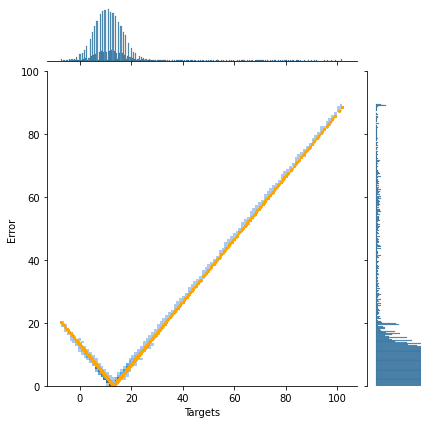

In [50]:
if dm.regression:
    #df_nona = pred_df.dropna(subset=["targets"]).reset_index()
    #mean_pred_error = (df_nona["targets"] - dm.preprocessor.mean_train_target).dropna() ** 2
    #error = (df_nona["targets"] - df_nona["preds"]) ** 2
    #df_nona["error"] = error
    plot_df = pd.DataFrame({"Targets": flat_targets, "Preds": flat_preds})
    plot_df["Error"] = (plot_df["Targets"] - plot_df["Preds"]).abs().tolist()
    ax = sns.jointplot(x="Targets", y="Error", data=plot_df, kind="hist", bins=100) # data=by_pat
    ax.ax_joint.scatter(plot_df["Targets"], (np.ones(len(plot_df["Targets"])) * dm.preprocessor.mean_train_target - plot_df["Targets"]).abs(), s=2, color="orange")
    plt.xlim(-20, 100)
    plt.ylim(0, 100)

In [51]:
#if dm.regression:
#    ylim = (df_nona["preds"].min() - 5, df_nona["preds"].max() + 5)
#    ax = sns.jointplot(data=df_nona, x="targets", y="preds", kind="reg", ylim=ylim) # data=bypat
#    min_val = df_nona["targets"].min()
#    max_val = df_nona["targets"].max()
#    ax.ax_joint.plot([min_val, max_val], [min_val, max_val], linewidth=2, color="black", label="Ideal model")

tensor(-7.1330) tensor(102.)


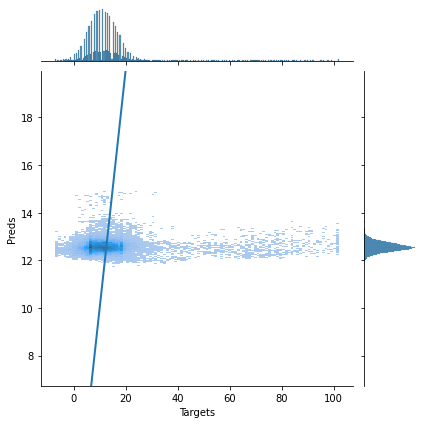

In [52]:
if dm.regression:
    ylim = (flat_preds.min() - 5, flat_preds.max() + 5)
    min_val = flat_targets.min()
    max_val = flat_targets.max()
    plot_df = pd.DataFrame({"Targets": flat_targets, "Preds": flat_preds})
    ax = sns.jointplot(x="Targets", y="Preds", data=plot_df, kind="hist", bins=100, ylim=ylim)
    print(min_val, max_val)
    # draw line of perfect correlation
    ax.ax_joint.plot([min_val, max_val], [min_val, max_val], linewidth=2)#, color="black")
    #ax.ax_joint.set_xlabel("test")

tensor(-7.1330) tensor(102.)


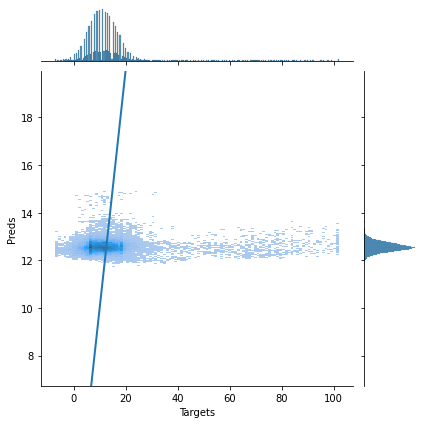

In [55]:
if dm.regression:
    ylim = (flat_preds.min() - 5, flat_preds.max() + 5)
    min_val = flat_targets.min()
    max_val = flat_targets.max()
    ax = sns.jointplot(data=plot_df, x="Targets", y="Preds", kind="hist", bins=100, ylim=ylim)
    print(min_val, max_val)
    # draw line of perfect correlation
    ax.ax_joint.plot([min_val, max_val], [min_val, max_val], linewidth=2)#, color="black")

In [56]:
if dm.regression:
    #pats = df.groupby("ids").filter(lambda x: x['preds'].max() > 16)
    pats = pred_df.groupby("ids").filter(lambda x: x['targets'].mean() > 20)
    #pats = df.groupby("ids").filter(lambda x: np.sqrt(x['error'].mean()) > 30)
else:
    pats = pred_df.groupby("ids").filter(lambda x: x['preds'].mean() > 0.2)
pats = pats.groupby("ids").filter(lambda x: len(x["targets"].dropna()) > 2)

ids = pats["ids"].unique()
print(ids)
print(len(ids), "patients")
#pats

[  5.  15.  16.  24.  25.  28.  30.  46.  66.  80.  82.  84.  89. 103.
 107. 108. 124. 137. 143. 150. 162. 163. 169. 173. 177. 184. 190.]
27 patients


mean average target:  13.218420179278507
mean pat targets:  36.998650394086695
R2 of model:  -1.7860797018635926
RMSE of model: 30.57
RMSE of mean: 30.01
MAPE of model:  0.67
MAPE of mean:  0.65


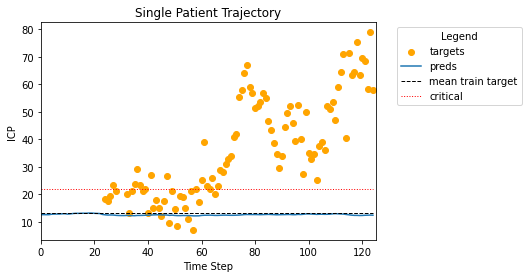

In [57]:
from icp_pred.eval_utils import mape
import sklearn

pat_id = 23
model_id = 0

pat = pred_df[pred_df["ids"] == ids[pat_id]]
pat = pat[pat["model_id"] == model_id]
if not dm.regression:
    pat["preds"] = torch.sigmoid(torch.tensor(pat["preds"].to_numpy())).numpy()


plt.scatter(pat["step"], pat["targets"], label="targets", color="orange")
plt.plot(pat["step"], pat["preds"], label="preds")
mean = dm.preprocessor.mean_train_target
print("mean average target: ", mean)
print("mean pat targets: ", pat["targets"].mean())
plt.plot([0, max(pat["step"])], [mean, mean], linewidth=1, color="black", label="mean train target", linestyle="--")
if dm.regression:
    plt.plot([0, max(pat["step"])], [22, 22], linewidth=1, color="red", label="critical", linestyle=":")

#plt.legend(location="out")
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0, max(pat["step"]) + 1)
plt.ylabel("ICP")
plt.xlabel("Time Step")
plt.title("Single Patient Trajectory")
pat_nona = pat[~pat["targets"].isna()]
print("R2 of model: ", sklearn.metrics.r2_score(pat_nona["targets"], pat_nona["preds"]))
print("RMSE of model:", round(np.sqrt(sklearn.metrics.mean_squared_error(pat_nona["targets"], pat_nona["preds"])), 2))
print("RMSE of mean:", round(np.sqrt(sklearn.metrics.mean_squared_error(pat_nona["targets"], [mean] * len(pat_nona))), 2))
print("MAPE of model: ", round(mape(pat_nona["targets"], pat_nona["preds"]), 2))
print("MAPE of mean: ", round(mape(pat_nona["targets"], [mean] * len(pat_nona)), 2))

In [58]:
#for i in range(len(dm.train_ds.targets)):
#    d = dm.train_ds.targets[i]
#    d = d[~torch.isnan(d)].max()
#    print(d)

## Saliency

In [59]:
feature_names = dm.feature_names

In [60]:
import shap


def classical_saliency(models, dms, model_type, use_shap=False, verbose=True):
    # plot feature importance
    all_importances = []
    all_inputs = []
    
    for model, data_module in zip(models, dms):
        if use_shap:
            explainer = shap.TreeExplainer(model)
            inputs = data_module.val_dataloader().dataset.flat_inputs
            importances = explainer.shap_values(inputs)
            all_inputs.append(inputs)
        else:
            if hasattr(model, "feature_importances_"):
                importances = model.feature_importances_
            elif hasattr(model, "coef_"):
                importances = model.coef_
        all_importances.append(importances)
    if not use_shap and verbose and hasattr(model, "importance_type"):
        print("Importance type: ", model.importance_type)
    print("importances shapes:")
    for imp in all_importances:
        print(imp.shape)
    importances = np.concatenate(all_importances)
    inputs = np.concatenate(all_inputs)
    mean_importances = importances.mean(axis=0)
    # save
    path = f"outputs/{model_type}"
    os.makedirs("outputs", exist_ok=True)
    
    block_size = cfg["flat_block_size"]

    
    if use_shap:
        #shap.summary_plot(mean_importances, X_test, plot_type="bar")
        #shap.summary_plot(mean_importances, X_test)
        #shap.summary_plot(mean_importances)
        #input_df = pd.DataFrame(inputs, columns=feature_names)
        #shap_df = pd.DataFrame(mean_importances, columns=feature_names)
        
        #vals= np.abs(shap_values).mean(0)
        #feature_importance = pd.DataFrame(list(zip(feature_names, vals)),columns=['col_name','feature_importance_vals'])
        #feature_importance = feature_importance.sort_values(by=['feature_importance_vals'], ascending=False)
        #feature_importance.head()
                
        if verbose:
            if block_size < 2:
                block_feat_names = feature_names
            else:
                block_feat_names = []
                for i in range(block_size):
                    block_feat_names.extend([f + f"_{i}" for f in feature_names])
            shap.summary_plot(importances, features=inputs, 
                              feature_names=block_feat_names)
            plt.savefig(path + "_shap_importances.jpg", bbox_inches='tight')
        
        
        # average over block_size/time_steps
       
        if block_size > 1:
            print(mean_importances.shape)
            mean_importances = mean_importances.reshape(-1, len(feature_names), block_size).mean(axis=-1)
            print(mean_importances.shape)


        imp_per_feat = np.abs(mean_importances).mean(axis=0)
        feat_df = pd.Series(imp_per_feat, index=feature_names)
    else:
        # make plot
        if block_size > 1:
            print(mean_importances.shape)
            mean_importances = np.abs(mean_importances.reshape(len(feature_names), block_size)).mean(axis=-1)
            print(mean_importances.shape)
        
        
        feat_df = pd.Series(mean_importances, index=feature_names)
        if verbose:
            p = feat_df.sort_values().plot.barh(figsize=(4, 25))
            p.figure.savefig(path + "_importances.jpg", bbox_inches='tight')
        
    feat_df = feat_df.sort_values(ascending=True)
    return feat_df


def reduce_feat_df(feat_df, threshold=0.2):
    # remove everything above 90% explained importance
    print(len(feat_df))
    feat_df = feat_df / feat_df.sum()
    reduced_df = feat_df[feat_df.cumsum() > threshold]
    print(len(reduced_df))
    print(reduced_df.sum())
    print(reduced_df)
    reduced_feats = list(reduced_df.index)
    return reduced_feats


In [61]:
if cfg["model_type"] in ["xgb", "log"]:
    sal_df = classical_saliency(models, dms, cfg["model_type"], 
                                use_shap=True, verbose=True)
    
    sal_df_normed = sal_df / sal_df.sum()
    sal_df_normed.sort_values().iloc[-10:]
    
    reduced_feats = reduce_feat_df(sal_df, threshold=0.15)
    reduced_feats

In [62]:
models[0].cpu()
torch.cuda.empty_cache()

In [63]:
dms

In [66]:
import icp_pred.saliency
from icp_pred.saliency import get_sal_list
import importlib
importlib.reload(icp_pred.saliency)

torch.cuda.empty_cache()


if not cfg["model_type"] in ["xgb", "log"]:

    sal_list = []
    for model, dm in zip(models, dms):
        model.cuda()
        max_backprop_len = 128 
        model_saliency = get_sal_list(model, 0, perc=1.0, agg=True, 
                                      ds=dm.val_dataloader().dataset, 
                                      ig=False, max_len=max_backprop_len)
        sal_list.append(model_saliency)
        model.cpu()
        torch.cuda.empty_cache()


100%|████████████████████████████████████████| 195/195 [00:01<00:00, 107.56it/s]


In [67]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [68]:
len(sal_list)

1

In [69]:
# TODO: average over multiple models!
#for sal in sal_list:

mean_overall = [s.mean(0) for s in sal_list[0]]
feat_saliency = np.sum(mean_overall, axis=0)
feature_names = dm.feature_names
feat_sal_df = pd.DataFrame({"sal": feat_saliency}, index = feature_names).sort_values("sal")

<Figure size 432x288 with 0 Axes>

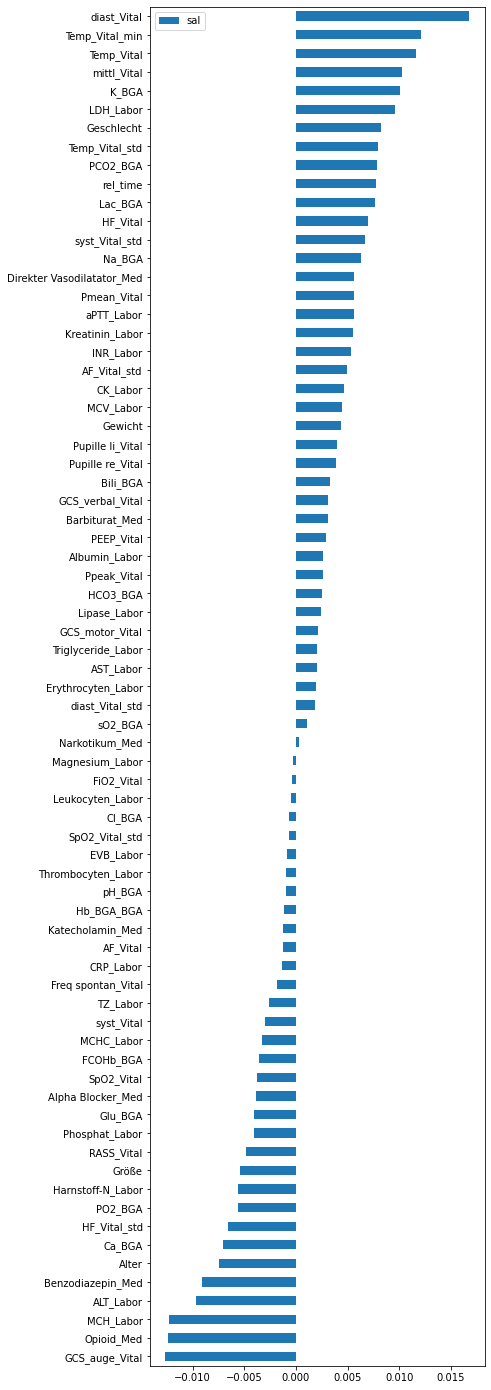

In [70]:
plt.figure()
p = feat_sal_df.plot.barh(figsize = (6, 25))

In [71]:
p.figure.savefig("importances.jpg", bbox_inches='tight')

In [72]:
plt.show()

In [73]:
len(feature_names)

73

In [74]:
sal = sal_list[0]

all_steps = []
for i, s in enumerate(sal):
    pat_df = pd.DataFrame(s, columns=feature_names)
    pat_df["pat_id"] = i
    pat_df["step"] = np.arange(s.shape[0])
    all_steps.append(pat_df)
sal_df = pd.concat(all_steps, axis=0)

In [75]:
pred_df

,targets,preds,ids,step,error,model_id,mean_train_target,std_train_target
0,-5.999999,12.525763,0.0,0,3.192929,0,13.21842,10.367677
1,-8.499998,12.481745,0.0,1,4.095625,0,13.21842,10.367677
2,-8.000000,12.497239,0.0,2,3.908659,0,13.21842,10.367677
3,-8.000000,12.498789,0.0,3,3.909250,0,13.21842,10.367677
4,-8.999998,12.488508,0.0,4,4.295854,0,13.21842,10.367677
...,...,...,...,...,...,...,...,...
46188,-0.666667,12.627929,194.0,307,1.644324,0,13.21842,10.367677
46189,0.666667,12.640356,194.0,308,1.333807,0,13.21842,10.367677
46190,-0.499999,12.572883,194.0,309,1.589936,0,13.21842,10.367677
46191,-0.999999,12.593616,194.0,310,1.719123,0,13.21842,10.367677


In [76]:
dl_type

'val'

In [77]:
N = 4

# kick out pats with less than N measurements
sal_df_min_N = sal_df[sal_df.groupby("pat_id").step.transform(len) >= N]
# calculate N averaged steps per patient
averaged_df = []
for pat_id in sal_df_min_N.pat_id.unique():
    pat_df = sal_df_min_N[sal_df_min_N.pat_id == pat_id]
    parts = np.array_split(pat_df, N)
    for part in parts:
        averaged_df.append(part.mean())
averaged_df = pd.DataFrame(averaged_df)

In [78]:
pred_df.columns

Index(['targets', 'preds', 'ids', 'step', 'error', 'model_id',
       'mean_train_target', 'std_train_target'],
      dtype='object')

In [79]:
# do the same as above for pred_df

# kick out pats with less than N measurements
pred_df_min_N = pred_df[pred_df.groupby("ids").step.transform(len) >= N]
# calculate N averaged steps per patient
averaged_pred_df = []
for pat_id in pred_df_min_N.ids.unique():
    pat_df = pred_df_min_N[pred_df_min_N.ids == pat_id]
    parts = np.array_split(pred_df_min_N, N)
    for part in parts:
        mean_part = part.mean()
        mean_part = mean_part / mean_part.sum()
        averaged_pred_df.append(mean_part)
averaged_pred_df = pd.DataFrame(averaged_pred_df)

In [80]:
averaged_pred_df

,targets,preds,ids,step,error,model_id,mean_train_target,std_train_target
0,0.039172,0.039177,0.062874,0.782946,0.002327,0.0,0.041194,0.032310
1,0.038336,0.039838,0.181674,0.663907,0.002027,0.0,0.041594,0.032624
2,0.040318,0.039930,0.343915,0.494897,0.006074,0.0,0.041957,0.032909
3,0.039604,0.035028,0.454095,0.401598,0.003582,0.0,0.037041,0.029053
4,0.039172,0.039177,0.062874,0.782946,0.002327,0.0,0.041194,0.032310
...,...,...,...,...,...,...,...,...
775,0.039604,0.035028,0.454095,0.401598,0.003582,0.0,0.037041,0.029053
776,0.039172,0.039177,0.062874,0.782946,0.002327,0.0,0.041194,0.032310
777,0.038336,0.039838,0.181674,0.663907,0.002027,0.0,0.041594,0.032624
778,0.040318,0.039930,0.343915,0.494897,0.006074,0.0,0.041957,0.032909


In [81]:
#averaged_df

In [82]:
averaged_df

,rel_time,AF_Vital,AF_Vital_std,ALT_Labor,AST_Labor,Albumin_Labor,Bili_BGA,CK_Labor,CRP_Labor,Ca_BGA,...,Geschlecht,Alpha Blocker_Med,Barbiturat_Med,Benzodiazepin_Med,Direkter Vasodilatator_Med,Katecholamin_Med,Narkotikum_Med,Opioid_Med,pat_id,step
0,0.000256,-0.000208,-0.000091,-0.000066,-2.413047e-06,0.000028,0.000090,0.000057,9.457361e-05,-0.000217,...,0.000140,-0.000120,2.500730e-04,0.000062,0.000192,0.000155,0.000269,-0.000313,0.0,2.0
1,0.000273,-0.000198,-0.000052,-0.000198,-1.985858e-05,-0.000081,0.000183,0.000032,8.292617e-05,-0.000255,...,-0.000063,-0.000116,1.436663e-04,-0.000011,0.000084,0.000111,0.000339,-0.000247,0.0,7.0
2,0.000252,-0.000003,-0.000072,-0.000084,7.760990e-05,0.000152,0.000184,0.000148,-9.157560e-07,0.000075,...,-0.000008,0.000052,1.411473e-04,0.000104,0.000096,0.000180,0.000359,-0.000202,0.0,12.0
3,-0.000031,0.000165,0.000148,-0.000098,1.256237e-04,0.000021,0.000228,-0.000009,-1.447091e-05,0.000102,...,0.000155,-0.000090,2.150211e-05,0.000043,0.000106,-0.000093,0.000066,-0.000332,0.0,17.0
4,0.000016,-0.000032,0.000012,-0.000039,1.953259e-05,-0.000012,-0.000010,0.000049,-3.689033e-05,-0.000012,...,0.000013,-0.000009,6.540347e-06,-0.000040,-0.000023,-0.000003,0.000011,-0.000036,1.0,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,0.000034,0.000029,0.000016,0.000016,1.105887e-05,0.000023,-0.000004,-0.000010,1.580134e-05,-0.000037,...,0.000040,-0.000022,3.441002e-06,-0.000022,0.000034,0.000022,-0.000014,-0.000008,193.0,400.5
776,0.000045,0.000009,0.000035,-0.000027,5.314430e-07,0.000024,0.000006,0.000005,-4.869951e-06,-0.000010,...,0.000011,0.000009,3.759513e-07,-0.000015,0.000006,0.000012,0.000025,-0.000004,194.0,38.5
777,0.000030,0.000007,0.000023,-0.000021,-4.140792e-07,0.000021,0.000007,0.000008,-6.193588e-06,-0.000020,...,0.000032,0.000004,-6.352415e-06,-0.000028,0.000008,-0.000006,0.000005,-0.000019,194.0,116.5
778,0.000048,-0.000001,0.000035,-0.000030,5.742138e-06,0.000007,0.000020,0.000011,-1.770820e-05,-0.000010,...,0.000004,0.000013,-7.942022e-06,-0.000039,-0.000022,0.000009,0.000023,-0.000024,194.0,194.5


In [83]:
# train umap on averaged steps
from umap import UMAP
umapper = UMAP(n_neighbors=10, min_dist=0.1)
sal_data = averaged_df.drop(columns=["pat_id", "step"])
umap_embedding = umapper.fit_transform(sal_data)

In [84]:
averaged_df

,rel_time,AF_Vital,AF_Vital_std,ALT_Labor,AST_Labor,Albumin_Labor,Bili_BGA,CK_Labor,CRP_Labor,Ca_BGA,...,Geschlecht,Alpha Blocker_Med,Barbiturat_Med,Benzodiazepin_Med,Direkter Vasodilatator_Med,Katecholamin_Med,Narkotikum_Med,Opioid_Med,pat_id,step
0,0.000256,-0.000208,-0.000091,-0.000066,-2.413047e-06,0.000028,0.000090,0.000057,9.457361e-05,-0.000217,...,0.000140,-0.000120,2.500730e-04,0.000062,0.000192,0.000155,0.000269,-0.000313,0.0,2.0
1,0.000273,-0.000198,-0.000052,-0.000198,-1.985858e-05,-0.000081,0.000183,0.000032,8.292617e-05,-0.000255,...,-0.000063,-0.000116,1.436663e-04,-0.000011,0.000084,0.000111,0.000339,-0.000247,0.0,7.0
2,0.000252,-0.000003,-0.000072,-0.000084,7.760990e-05,0.000152,0.000184,0.000148,-9.157560e-07,0.000075,...,-0.000008,0.000052,1.411473e-04,0.000104,0.000096,0.000180,0.000359,-0.000202,0.0,12.0
3,-0.000031,0.000165,0.000148,-0.000098,1.256237e-04,0.000021,0.000228,-0.000009,-1.447091e-05,0.000102,...,0.000155,-0.000090,2.150211e-05,0.000043,0.000106,-0.000093,0.000066,-0.000332,0.0,17.0
4,0.000016,-0.000032,0.000012,-0.000039,1.953259e-05,-0.000012,-0.000010,0.000049,-3.689033e-05,-0.000012,...,0.000013,-0.000009,6.540347e-06,-0.000040,-0.000023,-0.000003,0.000011,-0.000036,1.0,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,0.000034,0.000029,0.000016,0.000016,1.105887e-05,0.000023,-0.000004,-0.000010,1.580134e-05,-0.000037,...,0.000040,-0.000022,3.441002e-06,-0.000022,0.000034,0.000022,-0.000014,-0.000008,193.0,400.5
776,0.000045,0.000009,0.000035,-0.000027,5.314430e-07,0.000024,0.000006,0.000005,-4.869951e-06,-0.000010,...,0.000011,0.000009,3.759513e-07,-0.000015,0.000006,0.000012,0.000025,-0.000004,194.0,38.5
777,0.000030,0.000007,0.000023,-0.000021,-4.140792e-07,0.000021,0.000007,0.000008,-6.193588e-06,-0.000020,...,0.000032,0.000004,-6.352415e-06,-0.000028,0.000008,-0.000006,0.000005,-0.000019,194.0,116.5
778,0.000048,-0.000001,0.000035,-0.000030,5.742138e-06,0.000007,0.000020,0.000011,-1.770820e-05,-0.000010,...,0.000004,0.000013,-7.942022e-06,-0.000039,-0.000022,0.000009,0.000023,-0.000024,194.0,194.5


In [85]:
# plot umap
import umap.plot
#umap.plot.points(umapper, labels=averaged_df.pat_id)
umap.plot.points(umapper, 
                 #values=averaged_df.Katecholamin_Med,
                 values=averaged_pred_df["error"],
                 theme="fire")

ImportError: umap.plot requires pandas matplotlib datashader bokeh holoviews scikit-image and colorcet to be installed

In [ ]:
plot_df = pd.DataFrame(umap_embedding, columns=["x", "y"])
plot_df["cluster"] = cluster_labels
plot_df["error"] = averaged_pred_df["error"]

In [ ]:
sns.lmplot(x="x", y="y", data=plot_df, fit_reg=False,
           #hue='error',
           col="error",
           legend=True)

In [ ]:
plt.figure(figsize=(10,10))
sns.lmplot(x="x", y="y", data=plot_df, fit_reg=False,
           hue='error',
           #col="cluster",
           #row="error",
           legend=True,
          )

In [ ]:
# cluster averaged using K-means
from sklearn.cluster import KMeans
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
#clustering_data = sal_data
clustering_data = umap.UMAP(n_neighbors=10, min_dist=0.1).fit_transform(sal_data)
kmeans.fit(clustering_data)
cluster_labels = kmeans.labels_

In [ ]:
# label histogram
plt.figure()
plt.hist(cluster_labels, bins=10)

In [ ]:
plot_df

In [ ]:
sns.lmplot( x="x", y="y", data=plot_df, fit_reg=False, hue='cluster', legend=True)

In [ ]:
# show boxplots next to each other of each cluster
# sort columns by overall absolute mean importance value

# make subplots
fig, axes = plt.subplots(nrows=1, ncols=n_clusters, figsize=(10, 10), sharey=True)
for i in range(n_clusters):
    ax = axes[i]
    data = sal_data[cluster_labels == i]
    sns.stripplot(data=data, orient="h", palette="Set2", color=".25", alpha=0.3, ax=ax)
    sns.boxplot(data=data, orient="h", palette="Set2", showfliers=False, ax=ax)

In [ ]:
# print boxplot for each feature per clusters
for i in range(np.max(cluster_labels) + 1):
    cluster_data = sal_data[cluster_labels == i]
    # sort feature columns by absolute value
    mean_abs = cluster_data.abs().mean(axis=0)
    sorted_data = sorted(cluster_data.transpose().values, key=lambda x: np.abs(x).mean())
    sorted_columns = sorted(cluster_data.columns, key=lambda x: np.abs(cluster_data[x]).mean())
    # only show top N
    N = 6
    sorted_data = sorted_data[-N:] 
    sorted_columns = sorted_columns[-N:]
    
    # now sort by mean value without abs
    mean_data = cluster_data.mean(axis=0)
    sorted_data = sorted(sorted_data, key=lambda x: x.mean())
    sorted_columns = sorted(sorted_columns, key=lambda x: mean_data[x])
    
    # show boxplot where the feature name is at the y-axis
    #plt.figure(figsize=(5, 5))
    #plt.boxplot(sorted_data, labels=sorted_columns, whis=1.5, vert=False)
    #plt.show()
    # show variant where each single point is shown
    #plt.figure(figsize=(5, 5))
    #plt.scatter(cluster_data.index, cluster_data[sorted_columns[0]], c=cluster_labels)
    sorted_df = pd.DataFrame(sorted_data, index=sorted_columns)
    sns.stripplot(data=sorted_df.transpose(), orient="h", palette="Set2", color=".25", alpha=0.3)
    sns.boxplot(data=sorted_df.transpose(), orient="h", palette="Set2", showfliers=False)
    plt.xlim(-0.04, 0.04)
    #sns.stripplot(data=sorted_df.transpose(), orient="h", palette="Set2", color=".25")
    plt.show()
    

In [ ]:
sns.stripplot(data=sorted_df.transpose(), orient="h", palette="Set2", color=".25", alpha=0.3)
sns.boxplot(data=sorted_df.transpose(), orient="h", palette="Set2", showfliers=False)
plt.show()

# Tuning

In [ ]:
from tune_utils import tune#, make_tune_plots
from data_utils import make_split

import importlib
import tune_utils
importlib.reload(tune_utils)
from tune_utils import tune

import data_utils
importlib.reload(data_utils)

In [ ]:
import logging
import pytorch_lightning

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
logging.getLogger("lightning").setLevel(logging.ERROR)
pytorch_lightning.utilities.distributed.log.setLevel(logging.ERROR)

In [ ]:
cfg["dbs"] = ["UKE"]
cfg["k_fold"] = 0
cfg["num_splits"] = 3
cfg["flat_block_size"] = 0
cfg["n_trials"] = 15
cfg["model_type"] = "linear"
cfg["fill_type"] = "pat_mean"

cfg["max_steps"] = 300

opt_flat_block_size = False
opt_augs = False
opt_fill_type = False

In [ ]:
#storage = optuna.storages.RDBStorage(url="sqlite:///optuna.db",
#                                         engine_kwargs={"connect_args": {"timeout": 30}})
#load_study = optuna.load_study("09_17_02_39__linear_UKE_15", storage=storage)

In [ ]:
# make dev/test split to test tuning
dev_data, test_data, dev_idcs, test_idcs = make_split(seq_list, test_size=0.2)

In [ ]:
# tune
study = tune(dev_data, test_data, args, cfg, verbose=False, n_trials=cfg["n_trials"],
             opt_flat_block_size=opt_flat_block_size, opt_augs=opt_augs, opt_fill_type=opt_fill_type)

In [ ]:
#test_idcs = np.load("test_tune/09_17_02_39__linear_UKE_15/test_idcs.npy")

In [ ]:
# print key study parts
name = study.study_name
print(name)
print(study.best_trial)
best_params = study.best_params
print(best_params)

In [ ]:
from tune_utils import store_study_results
store_study_results(study, "./test_tune/", test_idcs, args)

In [ ]:
make_tune_plots(study, f"outputs/tune_results/{cfg['model_type']}_{cfg['n_trials']}")

In [ ]:
# retrain on dev/test and check performance
    
models, trainers = retrain(dev_data, test_data, best_params, args, cfg, verbose=True)

In [ ]:
cfg["k_fold"] = 0
cfg["num_splits"] = 5
models, trainers = retrain(dev_data, test_data, best_params, args, cfg, verbose=True)

In [ ]:
cfg["k_fold"] = 5
models, trainers = retrain(dev_data, test_data, best_params, args, cfg, verbose=True)

## Nested k-fold

In [ ]:
classical_models = ["xgb", "rf", "linear"]

In [ ]:
cfg["dbs"] = ["UKE"]
cfg["k_fold"] = 0
cfg["num_splits"] = 3
cfg["flat_block_size"] = 1
cfg["n_trials"] = 10

cfg["n_outer_folds"] = 3

cfg["model_type"] = "xgb"
cfg["fill_type"] = "pat_mean"

In [ ]:
from data_utils import make_fold
# outer fold
dev_data_list, test_data_list, dev_idcs, test_idcs = make_fold(seq_list, k=cfg["n_outer_folds"])

In [ ]:
# tune and store studies
studies = []
for dev_data, test_data in zip(dev_data_list, test_data_list):
    study = tune(dev_data, test_data, args, cfg, verbose=False, n_trials=cfg["n_trials"])
    # print key tune details
    name = study.study_name
    print(name)
    print(study.best_trial)
    best_params = study.best_params
    print(best_params)
    studies.append(study)

In [ ]:
metrics = []
pred_dfs = []
for tune_idx in tqdm(range(len(studies))):
    models, trainers = retrain(dev_data_list[tune_idx],
                               test_data_list[tune_idx], 
                               studies[tune_idx].best_params, 
                               args, cfg, verbose=False)
    df = get_all_dfs(models, trainers, cfg["model_type"], dl_type="test")
    #loss = print_all_metrics(df)
    loss = df.groupby("model_id").apply(lambda model_df: model_df.groupby("ids").mean()).mean()["error"]
    metrics.append(loss)
    pred_dfs.append(df)
    print(loss)

In [ ]:
print(np.mean(metrics))
print(np.std(metrics))

In [ ]:
for study in studies:
    print(study.best_value)
    print(study.best_params)
    print()

In [ ]:
[study.best_value for study in studies]

In [ ]:
metrics

In [ ]:
print(np.mean(metrics))
print(np.std(metrics))

In [ ]:
for study in studies:
    print(study.best_value)
    print(study.best_params)
    print()

In [ ]:
metrics

In [ ]:
len(studies)

In [ ]:
studies[0].best_trial